# Architectural Tradeoff Analysis (PCA)

In [10]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from paretoset import paretoset
import plotly.express as px

In [3]:
# Read simulation data
# Full = with SQS
df_full = pd.DataFrame(
    pd.read_csv(r"C:\Users\KarlO\architectural-tradeoff-analysis\Simulation data\official_runs\full_1.csv"))
# Simple = without SQS
df_simple = pd.DataFrame(
    pd.read_csv(r"C:\Users\KarlO\architectural-tradeoff-analysis\Simulation data\official_runs\simple_1.csv"))

df = pd.concat([df_full, df_simple])

In [14]:
df_scatter = df.copy()
df_scatter["e_SQS"] = df_scatter["e_SQS"].astype(str)
fig = px.scatter_matrix(df_scatter,
    dimensions=['queue_size', 'timeout','parallel_instances','lambda_chunk_size'],
    color="e_SQS",
    title = "Scatter matrix of parameters")
fig.update_traces(diagonal_visible=False)
fig.show()

In [162]:
df_copy = df.copy()
ct_df = df[['time', 'cost']]
ct_copy = ct_df.copy()
optimal = []

for i in range(10):
    mask = paretoset(ct_copy, sense=["min", "min"])
    masklist = mask.tolist()
    indices= [index for (index, item) in enumerate(masklist) if item == True]
    ct_copy.drop(ct_copy.index[indices], inplace=True)
    df_copy.drop(df_copy.index[indices], inplace=True)
    optimal += indices
    
df_optimal = df.iloc[optimal]

print(df_optimal)

      e_SQS  queue_size  timeout  e_S3  e_lambda  parallel_instances  \
450       1         600      6.0     1         1                   1   
3129      1        1000      8.0     1         1                   1   
3497      1         800      1.0     1         1                   2   
3828      1         600      0.8     1         1                   2   
8573      1        1000     10.0     1         1                   1   
...     ...         ...      ...   ...       ...                 ...   
1233      1          32      0.8     1         1                 120   
1244      1         700      0.5     1         1                  50   
3769      1         600      6.0     1         1                 600   
5308      1         100      5.0     1         1                  50   
6638      1         300      0.1     1         1                 120   

      lambda_chunk_size        time      cost  
450                 360    2.777778  0.000009  
3129                340    2.976190  0.

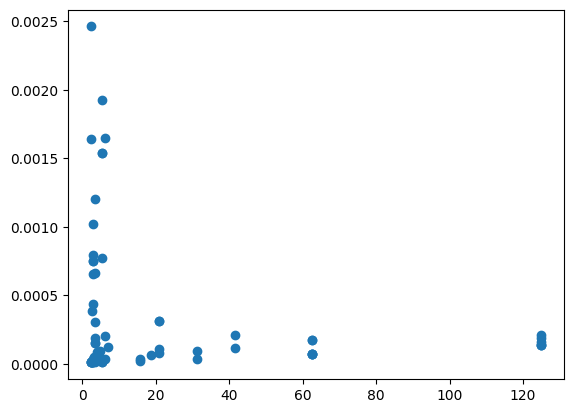

In [166]:
plt.scatter(df_optimal['time'], df_optimal['cost'])
plt.show()

In [168]:
# Scale dataframe (gets turned into ndarray which gets retransformed back to dataframe)
scaled_ndarr = preprocessing.scale(df_optimal)
scaled_df = pd.DataFrame(scaled_ndarr, columns = df_optimal.columns)

# Create correlation matrix

corr_matrix = scaled_df.corr()
corr_matrix = corr_matrix.fillna(0)
#corr_matrix = corr_matrix.drop(['cost','time'])
#corr_matrix = corr_matrix[['cost','time']]

In [169]:
corr_matrix_arr = corr_matrix.to_numpy()
pca = PCA()
#pca.fit(scaled_df)
pca.fit(corr_matrix_arr)
#pca_data = pca.transform(scaled_df)
pca_data = pca.transform(corr_matrix_arr)

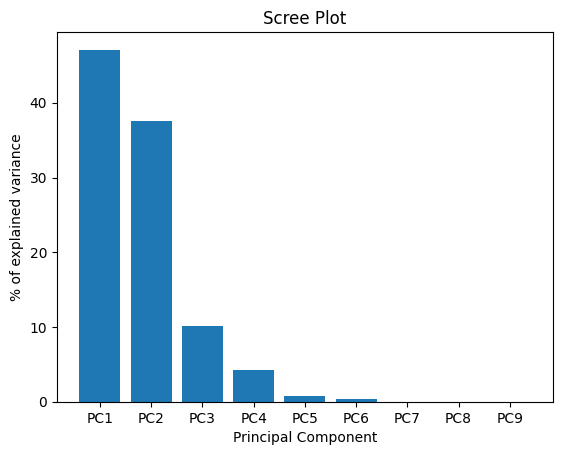

In [170]:
# Calculate percentage of variation that each PC (principal component) accounts for
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
# Create labels
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
# Plot scree plot
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('% of explained variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

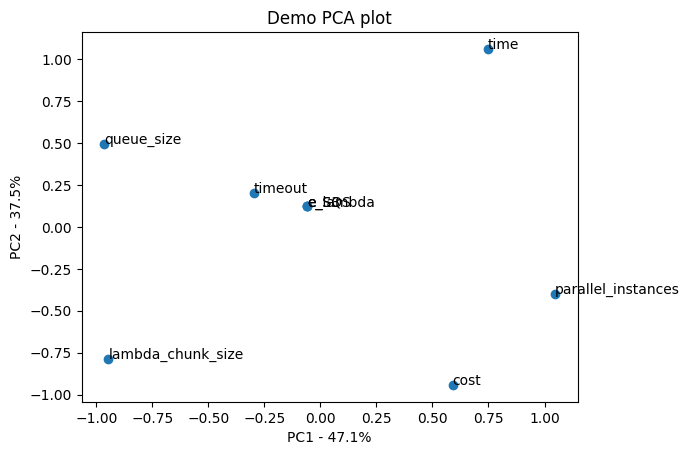

In [171]:
pca_df = pd.DataFrame(pca_data, index=corr_matrix.columns, columns=labels)

plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('Demo PCA plot')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
                 
plt.show()